In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".13"

In [2]:
import pandas as pd
from brain import BrainModel
from submodels import factories
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from random import shuffle

from lib.score import (
    fate_corr, score_both_size_norm, shrink_and_align_stats, score_stats_norm
)
from lib.preprocess import *
from lib.callback import (
    cell_number_callback, progenitor_number_callback, neuron_number_callback,
    TargetPopulation, TagNumberCallback,
)
from lib.sde.grn.grn5 import GRNMain5 as GRNMain
from lib.sde.mutate import mutate_grn5 as mutate_grn

from lib.ga.utils import weighted_selection_one, normalize_fitness_values
from lib.utils import pick_best, pick_last
from jf.utils.export import Exporter
from jf.autocompute.jf import O, L
from itertools import product
import jf.models.stringmodel as sm
from lib.analyser import show_curve_2, show_curve_progenitor
from jf.models.stringmodel import read_model

In [3]:
_count = -1
def provide_id():
    global _count
    _count += 1
    return _count

In [4]:
REF = O(
    stats=pd.read_csv("reference/ref_tristate2.csv"),  # ref is a mean
)
SM_GEN = read_model("generation")

In [18]:
def individual_generator(id_=-1, cb_init=None):
    sol = Solution(GRNMain(5, 0, 1, generate_funcs=cb_init), id_=id_)
    sol.grn.set_mutable()
    sol.grn.genes[0].init = 1
    sol.grn.compile()
    return sol

In [6]:
class Solution:
    def __init__(self, grn, id_=0, parent=-1):
        self.id = id_
        self.grn = grn
        self.parent = parent
        self.fit = -1
        self.stats = None
        
    def copy(self, id_=0):
        return Solution(self.grn.copy(), id_=id_, parent=self.id)
        
    def mutate(self):
        mutate_grn(self.grn)

In [7]:
def score_bb_size(bb, ref, *args, **kwargs):
    stats = bb.stats.copy()
    last_time = max(stats.time)
    stats = stats.set_index("time")
    prog = stats.loc[last_time]["progenitor_pop_size"]
    neuron = stats.loc[last_time]["neuron_pop_size"]
    # print(prog, neuron, neuron - prog**1.8)

    return 1 / max(1, 1000 + (neuron - prog**2))

In [8]:
def setup_tag(cp):
    indexes = list(cp.base_population.keys())
    shuffle(indexes)
    splits = np.array_split(indexes, 3)
    for i, ls in enumerate(splits):
        for idx in ls:
            cp.base_population[idx].tag["subbrain"] = i

In [9]:
def get_bb(prun, grn):
    ccls = factories["grn5"](grn=grn)
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
    )
    bb = BrainModel(time_step=0.25, verbose=False, start_population=prun.size, max_pop_size=5e2,
            cell_cls=ccls, end_time=prun.end_time, start_time=66, silent=True, opti=True,
              run_tissue=True, monitor_callbacks=callbacks, tag_func=setup_tag)
    return bb

In [10]:
def run_grn(prun, grn):
    get_bb(prun, grn)
    bb.run()
    return bb

In [11]:
def fitness_multistep(prun, grn, steps):
    total_fitness = 0
    stop = False
    previous_time = None
    bb = get_bb(prun, grn)
    # first step
    for step in steps:
        if not bb.run_until(step.end_time):
            stop = True
        
        score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
        fitness_step = 1.0 / score_step
        fitness_step = min(fitness_step, step.max_fitness)
        total_fitness += fitness_step
        if fitness_step < step.min_fitness or stop:
            return total_fitness, bb.stats
        else:
            previous_time = step.end_time
            step.passed()
        
    return total_fitness, bb.stats

In [12]:
def do_init(prun):
    return individual_generator(provide_id(), prun.cb_init)

def do_fitness(prun, sol):
    fitness, stats = fitness_multistep(prun, sol.grn, prun.steps)
    return fitness, stats

def do_selection(prun, pop_fit, pop):
    if len(pop) < prun.min_pop:
        return individual_generator(provide_id(), prun.cb_init)
    
    pop_fit = normalize_fitness_values(pop_fit)
    
    return weighted_selection_one(pop, pop_fit, lambda x: individual_generator(x, prun.cb_init), new_fitness=0.05, id_=provide_id())[0]

def do_mutation(prun, sol):
    sol.mutate()
    return sol

In [13]:
class ObjectiveStep(O):
    start_time = 0
    end_time = 0
    max_fitness = 1e9
    min_fitness = 1
    name = ""
    _passed = False
    
    def reset(self):
        self._passed = False
    
    def passed(self):
        if self._passed:
            return
        print(f"Step {self.name} passed !")
        self._passed = True
    
example_steps = [
    # ObjectiveStep(name="1", start_time=50, end_time=53, score_func=score_bb_size, min_fitness=0.2),
    # ObjectiveStep(name="2", start_time=53, end_time=56, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="3", start_time=56, end_time=86, score_func=score_bb_size, min_fitness=0.2),
]

class ParamRun(O):
    pop_size = 50
    batch_size = 50
    n_gen = 50
    current_gen = 0
    end_time = 86
    ref = REF
    min_pop = 50
    max_pop = 50

def get_prun(size=5, exponent=1):
    prun = ParamRun()
    prun.cb_init = dict()
    prun.size = size
    prun.exponent = exponent
    prun.steps = example_steps
    return prun

In [14]:
def pick_last_exported(exporter):
    generations = list(filter(SM_GEN.match, exporter.list()))
    if len(generations) == 0:
        return None, 0
    
    last = max(generations, key=lambda x: int(SM_GEN.extract(x).get("generation")))
    b_gen = int(SM_GEN.extract(last).get("generation")) + 1
    exporter.print(f"Found generation {b_gen - 1}", "reload")
    pop = exporter.load(last)
    return pop, b_gen

In [15]:
def main(prun):
    prun.history = dict()
    exporter = Exporter(name=prun.name, copy_stdout=True)
    definition = """
    
    """
    exporter.print(definition, slot="definition")
    best = 0
    
    # setup
    pop, batch_gen = pick_last_exported(exporter)
    
    if pop is None:
        sol = do_init(prun)
        pop = [sol]
        batch_gen = 0
    else:
        sol = pop[-1]
        
    for i in range(batch_gen * prun.batch_size,
                   prun.n_gen * prun.batch_size):
        fit, stats = do_fitness(prun, sol)
        sol.fit, sol.stats = fit, stats
        
        if i % 100 == 0:
            exporter.print(f"Step {i}")
        if fit > best:
            exporter.print(f"++ Best {fit} for generation {i}")
            best = fit
            
        monitor = sol
        prun.history[i] = monitor
        # exporter(monitor, f"generation_g{generation}")
        
        sub_pop = pop[-prun.max_pop:]
        sol = do_selection(prun, [s.fit for s in sub_pop], sub_pop)
            
        sol = do_mutation(prun, sol)
        pop.append(sol)
        
        if (i + 1) % prun.batch_size == 0:
            print("Saving ...")
            batch_gen = (i + 1) // 100
            exporter(pop[-prun.max_pop:], SM_GEN.fill(generation=batch_gen))
        
    return best

In [16]:
callback_init = dict(
    init=lambda: np.random.beta(1.5, 3) * 3,
    b=lambda: np.random.beta(1.5, 3) * 5,
    expr=lambda: 1,
    deg=lambda: 0.1,
    noise=lambda: np.random.beta(1.5, 3) * 1,
    asym=lambda: 5,
)

In [19]:
prun = get_prun()
prun.cb_init = callback_init
prun.name = "check_simple_obj_r17"
res = main(prun)

Exporting at output/check_simple_obj_r17
[definition] 
    
    
[out] Step 0
[out] ++ Best 1.0 for generation 0
[out] ++ Best 971.9999999999999 for generation 1
Step 3 passed !
[out] ++ Best 1001.0 for generation 19
[out] ++ Best 1013.0000000000001 for generation 20
[out] ++ Best 1024.0 for generation 33
[out] ++ Best 1029.0 for generation 38
Saving ...
[out] ++ Best 1030.0 for generation 72
Saving ...
[out] Step 100
Saving ...
[out] ++ Best 1034.0 for generation 161
Saving ...
[out] Step 200
Saving ...
Saving ...
[out] Step 300
Saving ...
[out] ++ Best 1037.0 for generation 397
Saving ...
[out] Step 400
[out] ++ Best 1041.0 for generation 418
Saving ...
Saving ...
[out] Step 500
Saving ...
[out] ++ Best 1119.0 for generation 583
[out] ++ Best 1145.0 for generation 590
[out] ++ Best 1151.0 for generation 594
[out] ++ Best 1155.0 for generation 595
[out] ++ Best 1848.0 for generation 597
Saving ...
[out] Step 600
[out] ++ Best 2813.0 for generation 608
[out] ++ Best 2942.9999999999995 

In [20]:
exp = Exporter(name=prun.name)

Exporting at output/check_simple_obj_r17


In [21]:
sm = read_model("generation")

In [22]:
res = pick_best(exp.load(pick_last(exp)))

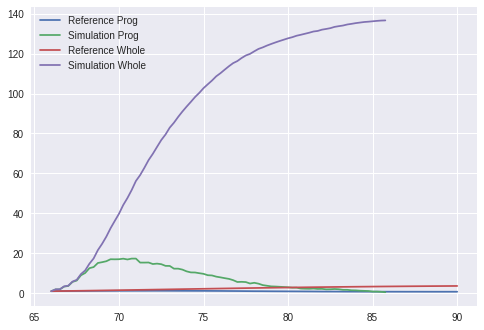

In [23]:
show_curve_2(res.stats, REF.stats)

In [24]:
for g in sorted(filter(sm.match, exp.list()), key=lambda x: int(sm.extract(x)["generation"])):
    gen = exp.load(g)
    res = pick_best(gen)
    print()
    print(f"======= GENERATION {g} =======")
    print(res.grn)


======= GENERATION generation_g0 =======
>> G_0: init: 1.00; noise: 0.33; b: 1.57; m: 6.80; expr: 1.00; deg: 0.10; theta: 5.06; asym: 5.00; tree : ((4 AND -1) OR -3)
>> G_1: init: 0.37; noise: 0.06; b: 0.81; m: 5.53; expr: 1.00; deg: 0.10; theta: 0.01; asym: 5.00; tree : -1
>> G_2: init: 1.58; noise: 0.43; b: 0.74; m: 3.84; expr: 1.00; deg: 0.10; theta: 5.29; asym: 5.00; tree : -4
>> G_3: init: 0.53; noise: 0.49; b: 3.51; m: 8.50; expr: 1.00; deg: 0.10; theta: 7.41; asym: 5.00; tree : -3
>> G_4: init: 1.14; noise: 0.40; b: 1.64; m: 1.25; expr: 1.00; deg: 0.10; theta: 1.88; asym: 5.00; tree : 0

======= GENERATION generation_g1 =======
>> G_0: init: 1.00; noise: 0.33; b: 1.47; m: 6.80; expr: 1.00; deg: 0.10; theta: 5.06; asym: 5.00; tree : ((4 AND -1) OR -3)
>> G_1: init: 0.37; noise: 0.06; b: 0.81; m: 5.53; expr: 1.02; deg: 0.10; theta: 0.01; asym: 5.00; tree : -1
>> G_2: init: 1.58; noise: 0.43; b: 0.74; m: 3.84; expr: 1.00; deg: 0.10; theta: 5.29; asym: 5.00; tree : (-4 AND 3)
>> G_